In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
def corr2d(X,K):
    h,w=K.shape
    Y=torch.zeros((X.shape[0] - h+1,X.shape[1]-w+1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            #print(X[i:i+h,j:j+w])
            Y[i,j]=(X[i:i+h,j:j+w]*K).sum()
    return Y 


In [3]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

In [4]:
class Conv2D(nn.Module):
    def __init__(self,kernel_size) -> None:
        super().__init__() 
        self.weight=nn.Parameter(torch.rand(kernel_size))
        self.bias=nn.Parameter(torch.zeros(1))
    def forward(self,x):
        return corr2d(x,self.weight)+self.bias

In [5]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X,X.shape

(tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
         [1., 1., 0., 0., 0., 0., 1., 1.],
         [1., 1., 0., 0., 0., 0., 1., 1.],
         [1., 1., 0., 0., 0., 0., 1., 1.],
         [1., 1., 0., 0., 0., 0., 1., 1.],
         [1., 1., 0., 0., 0., 0., 1., 1.]]),
 torch.Size([6, 8]))

In [6]:
K = torch.tensor([[1.0, -1.0]])

In [7]:
Y = corr2d(X, K)
Y,Y.shape

(tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
         [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
         [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
         [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
         [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
         [ 0.,  1.,  0.,  0.,  0., -1.,  0.]]),
 torch.Size([6, 7]))

In [8]:
corr2d(X.T,K.T)

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  1.,  1.,  1.,  1.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [-1., -1., -1., -1., -1., -1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.]])

In [9]:
# 构造一个二维卷积层，它具有1个输出通道和形状为（1，2）的卷积核
conv2d = nn.Conv2d(1,1, kernel_size=(1, 2), bias=False)
X=X.reshape((1,1,6,8))
Y=Y.reshape((1,1,6,7))
lr=3e-2
for i in range(10):
    Y_hat=conv2d(X)
    l=(Y-Y_hat)**2 
    conv2d.zero_grad()# 这一步避免了梯度的积累积累
    l.sum().backward()# 什么时候调用这个函数，我其实没有弄明白，调用这个函数是对这个所有的计算图都进行的梯度计算？
    conv2d.weight.data[:]-=lr*conv2d.weight.grad
    if(i+1)%2==0:
        print(f'epoch {i+1}, loss {l.sum():.3f}')

epoch 2, loss 11.751
epoch 4, loss 3.055
epoch 6, loss 0.956
epoch 8, loss 0.342
epoch 10, loss 0.132


In [10]:
conv2d.weight.data,conv2d.weight.data.shape,conv2d.weight.data.reshape((1,2))

(tensor([[[[ 1.0227, -0.9493]]]]),
 torch.Size([1, 1, 1, 2]),
 tensor([[ 1.0227, -0.9493]]))

In [11]:
import torch
from torch import nn
from d2l import torch as d2l

net=nn.Sequential(
    nn.Conv2d(1,6,kernel_size=5,padding=2),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    nn.Conv2d(6,16,kernel_size=5),nn.ReLU(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    nn.Flatten(),
    nn.Linear(16*5*5,120)    ,nn.ReLU(),
    nn.Linear(120,84),nn.ReLU(),
    nn.Linear(84,10)
)

In [12]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
ReLU output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
ReLU output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
ReLU output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
ReLU output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [13]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [14]:
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [15]:
#@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            #print(i)
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.274, train acc 0.898, test acc 0.881
52174.0 examples/sec on cuda:0


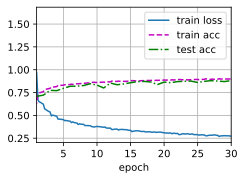

In [18]:
lr, num_epochs = 0.05, 30
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [ ]:
lenet 
- 将SIGMOD函数替换成了relu函数
- lenet的网络结构，将图片的通道数逐步变宽。
- 1x1 的卷积是把各个通道元素链接时做了一个全连接。
其他
- pytorch的输出的shape是四维的：(batch_size,)
需要多次学习的内容
- 如何估算一个模型的计算时间【未掌握】
- 上一层的特征，通过核做特征变换之后的长宽计算公式。

In [ ]:
# 需要经常学的代码：
# 打印网络结构

X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

# 将数据放到gpu中
X = X.to(device) 

# 网络定义和训练
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights) # 初始化模型的参数
    print('training on', device)
    net.to(device) # 网络放在gpu中训练
    optimizer = torch.optim.SGD(net.parameters(), lr=lr) # 梯度优化算法，和网络关联起来。
    loss = nn.CrossEntropyLoss() #交叉熵
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')
